In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import cv2 as cv
import json
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

In [2]:
# directory with the coco images
dir_ = "D:/Datasets/COCO/Images/train2014/"

# directory with the annotations bounding boxes
data_annotation_path = "D:/Datasets/COCO/Annotations/annotations/instances_train2014.json"

In [3]:
# initialize COCO api for instance annotations
coco=COCO(data_annotation_path)

loading annotations into memory...
Done (t=9.24s)
creating index...
index created!


In [40]:
def get_images_batch_from_COCO(batch_size, coco):
    ''' This function produce the batches for the training'''
    
    while True:
        # iamges batch
        batch = []
        batch_anns  = []
        for i in range(batch_size):
            
            # get all images containing given categories, select one at random
            catIds = coco.getCatIds(catNms=coco.cats)

            # get all images through their IDs
            imgIds = coco.getImgIds(catIds=catIds )

            # random select an image and its annotations
            img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
            annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)

            ### load the image and the annotations ###
            image = cv.imread(os.path.join(dir_,img["file_name"]))
            # cvtColor changes the color conversion
            rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            image_H = rgb_image.shape[0]
            image_W = rgb_image.shape[1]
            
            #load annotations
            anns = coco.loadAnns(annIds)

            # append the image to the batch and annotations to batch_anns
            batch.append(rgb_image)
            batch_anns.append(parse_annotations(anns,image_H,image_W))
            
        yield batch, batch_anns
        
def parse_annotations(annotations,image_H,image_W):
    '''
    This function returns a list of lists. Each element of the main list contains the parameters of a of a bounding box:
    
    - x: center coordinate x 
    - y: center coordinate y 
    - w: width of the bounding box
    - h: height of the bounding box
    - class: class of the object inside the bounding box
    
    '''
    data = []
    for annotation in annotations:
        bbox = rescale_BB_coordinates(annotation['bbox'],image_H,image_W)
        category_id = annotation['category_id']
        bbox.append(category_id)
        data.append(bbox)
    return data

def rescale_BB_coordinates(data,image_H,image_W):
    '''rescale BB coordinates according to iamge dimensions:
    - output: center_x, center_y, width, height 
    - input: upper_left_x, upper_left_y, width, height'''
    data[0] = (data[0]+data[2]/2)/image_W # x
    data[1] = (data[1]+data[3]/2)/image_H # y
    data[2] = (data[2])/image_W # w 
    data[3] = (data[3])/image_H # h
    return data

def Draw_BB(orig_image, image_datas, coco, fontscale=.7, bb_thickness=2):
    
    '''Draw bounding boxes on an image
    
    - output: copy of the original image with overlapped BB
    - input: image, annotations for the image, coco '''
    
    # copy the original image to not modify the original
    image = np.copy(orig_image)
    image_H = image.shape[0]
    image_W = image.shape[1]
    
    for image_data in image_datas:
    
        # unpack image data
        x0, y0, w, h, label_ = image_data
        
        # rescale the center and dimensions of the BB
        cetnter_x = int(x0*image_W)
        center_y = int(y0*image_H)
        W = int(w*image_W)
        H = int(h*image_H)
        
        # build start and stop point for bb
        start_point = (cetnter_x-int(W/2), center_y+int(H/2))
        stop_point = (cetnter_x+int(W/2), center_y-int(H/2))

        # draw the rectangle
        image = cv.rectangle(image, start_point, stop_point, color=(0,0,255), thickness=5)

        # write BB class
        label = coco.cats[label_]['name']
        text_origin = start_point
        font = cv.FONT_HERSHEY_SIMPLEX 
        fontScale=fontscale
        color=(0,255,0)
        thickness=bb_thickness
        image = cv.putText(image, label, text_origin, font,  fontScale, color, thickness, cv.LINE_AA)

    
    return image

In [41]:
# build the generator
gen_ = get_images_batch_from_COCO(3, coco)

In [42]:
# get a batch
batch, anns = gen_.__next__()

In [45]:
# Draw BBox
test_image = Draw_BB(batch[1],anns[1],coco)

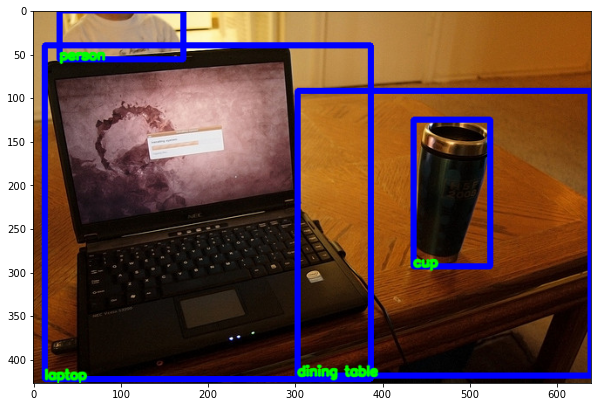

In [46]:
plt.figure(figsize=(10,10))
plt.imshow(test_image)